# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:12<00:00, 4.74KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
#pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

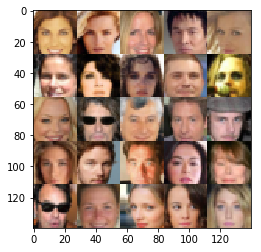

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01
    keep_prob = 0.8
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input Layer: 28 x 28 x 3
        # First Layer: 14 x 14 x 64
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        x1 = tf.layers.batch_normalization(x1, training=True)
        # Leaky RelUs
        x1 = tf.maximum(alpha*x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        
        # Second Layer: 7 x 7 x 128
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        # Third Layer: 4 x 4 x 256
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        
        x4 = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(x4, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    keep_prob = 0.8
    
    with tf.variable_scope('generator', reuse=not is_train):
        g1 = tf.layers.dense(z, 7*7*512)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha*g1, g1)
        # dimension of g1: 7 x 7 x 512
        
        g2 = tf.layers.conv2d_transpose(g1, 256, 5, strides=2, padding='SAME', activation=None)
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha*g2, g2)
        g2 = tf.nn.dropout(g2, keep_prob=keep_prob)
        # dimension of g2: 14 x 14 x 256
        
        g3 = tf.layers.conv2d_transpose(g2, 128, 5, strides=2, padding='SAME', activation=None)
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha*g3, g3)
        g3 = tf.nn.dropout(g3, keep_prob=keep_prob)
        # dimension of g3: 28 x 28 x 128
        
        logits = tf.layers.conv2d_transpose(g3, out_channel_dim, 3, strides=1, padding='SAME', activation=None)
        # dimension of logits: 28 x 28 x 5
        
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [13]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smoothing = 0.1
    g_output = generator(input_z, out_channel_dim)
    d_output_real, d_logits_real = discriminator(input_real)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_output_real)*(1-smoothing))
    )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_output_fake))
    )
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels = tf.ones_like(d_output_fake))
    )
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    total_steps = epoch_count * batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real:batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps == 1:
                    print('First Step: ')
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                
                if steps % 10 == 0:
                    d_train_loss = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    g_train_loss = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs), 
                         "Generator Loss: {:.4f}".format(g_train_loss),
                         "Discriminator Loss: {:.4f}...".format(d_train_loss))
                    losses.append((d_train_loss, g_train_loss))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
        
        saver.save(sess, './generator.ckpt')
    return losses
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [26]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

First Step: 


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Generator Loss: 3.8339 Discriminator Loss: 0.4103...
Epoch 1/2... Generator Loss: 4.3107 Discriminator Loss: 0.5656...
Epoch 1/2... Generator Loss: 8.2316 Discriminator Loss: 0.4655...
Epoch 1/2... Generator Loss: 5.1998 Discriminator Loss: 0.3903...
Epoch 1/2... Generator Loss: 5.2708 Discriminator Loss: 0.3758...
Epoch 1/2... Generator Loss: 1.5491 Discriminator Loss: 0.8942...
Epoch 1/2... Generator Loss: 6.4651 Discriminator Loss: 0.3961...
Epoch 1/2... Generator Loss: 5.1699 Discriminator Loss: 0.4585...
Epoch 1/2... Generator Loss: 1.6489 Discriminator Loss: 0.8943...
Epoch 1/2... Generator Loss: 2.1794 Discriminator Loss: 0.8575...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Generator Loss: 1.5620 Discriminator Loss: 0.9442...
Epoch 1/2... Generator Loss: 2.0346 Discriminator Loss: 1.1152...
Epoch 1/2... Generator Loss: 1.4864 Discriminator Loss: 0.9391...
Epoch 1/2... Generator Loss: 2.2961 Discriminator Loss: 1.1895...
Epoch 1/2... Generator Loss: 0.7080 Discriminator Loss: 1.2629...
Epoch 1/2... Generator Loss: 1.9280 Discriminator Loss: 1.1353...
Epoch 1/2... Generator Loss: 1.6741 Discriminator Loss: 1.1439...
Epoch 1/2... Generator Loss: 0.9773 Discriminator Loss: 1.1206...
Epoch 1/2... Generator Loss: 1.4788 Discriminator Loss: 0.9995...
Epoch 1/2... Generator Loss: 0.6170 Discriminator Loss: 1.4308...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Generator Loss: 2.3200 Discriminator Loss: 1.2631...
Epoch 1/2... Generator Loss: 1.5140 Discriminator Loss: 1.0020...
Epoch 1/2... Generator Loss: 1.4526 Discriminator Loss: 0.9905...
Epoch 1/2... Generator Loss: 1.8727 Discriminator Loss: 1.0607...
Epoch 1/2... Generator Loss: 0.7209 Discriminator Loss: 1.3202...
Epoch 1/2... Generator Loss: 0.8176 Discriminator Loss: 1.2244...
Epoch 1/2... Generator Loss: 1.5750 Discriminator Loss: 1.1988...
Epoch 1/2... Generator Loss: 0.9322 Discriminator Loss: 1.1425...
Epoch 1/2... Generator Loss: 1.0565 Discriminator Loss: 1.2253...
Epoch 1/2... Generator Loss: 0.6799 Discriminator Loss: 1.4189...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Generator Loss: 1.2856 Discriminator Loss: 1.1391...
Epoch 1/2... Generator Loss: 1.2266 Discriminator Loss: 1.1183...
Epoch 1/2... Generator Loss: 1.8956 Discriminator Loss: 1.3420...
Epoch 1/2... Generator Loss: 1.1635 Discriminator Loss: 1.1872...
Epoch 1/2... Generator Loss: 0.6544 Discriminator Loss: 1.3100...
Epoch 1/2... Generator Loss: 1.0264 Discriminator Loss: 1.1954...
Epoch 1/2... Generator Loss: 1.0297 Discriminator Loss: 1.1174...
Epoch 1/2... Generator Loss: 1.2877 Discriminator Loss: 1.0380...
Epoch 1/2... Generator Loss: 1.7360 Discriminator Loss: 1.2199...
Epoch 1/2... Generator Loss: 1.2762 Discriminator Loss: 1.1531...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Generator Loss: 0.8080 Discriminator Loss: 1.2402...
Epoch 1/2... Generator Loss: 1.2345 Discriminator Loss: 1.0887...
Epoch 1/2... Generator Loss: 1.4101 Discriminator Loss: 1.1541...
Epoch 1/2... Generator Loss: 1.6138 Discriminator Loss: 1.1513...
Epoch 1/2... Generator Loss: 1.0437 Discriminator Loss: 1.1052...
Epoch 1/2... Generator Loss: 1.0554 Discriminator Loss: 1.1107...
Epoch 2/2... Generator Loss: 1.0540 Discriminator Loss: 1.0831...
Epoch 2/2... Generator Loss: 0.8281 Discriminator Loss: 1.2143...
Epoch 2/2... Generator Loss: 1.0532 Discriminator Loss: 1.0417...
Epoch 2/2... Generator Loss: 1.0690 Discriminator Loss: 1.1354...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Generator Loss: 1.3922 Discriminator Loss: 1.1051...
Epoch 2/2... Generator Loss: 2.3204 Discriminator Loss: 1.3405...
Epoch 2/2... Generator Loss: 1.3767 Discriminator Loss: 1.1219...
Epoch 2/2... Generator Loss: 1.1231 Discriminator Loss: 1.1261...
Epoch 2/2... Generator Loss: 1.1715 Discriminator Loss: 1.0160...
Epoch 2/2... Generator Loss: 0.6911 Discriminator Loss: 1.2468...
Epoch 2/2... Generator Loss: 0.8914 Discriminator Loss: 1.1335...
Epoch 2/2... Generator Loss: 0.6904 Discriminator Loss: 1.3207...
Epoch 2/2... Generator Loss: 1.4005 Discriminator Loss: 1.1419...
Epoch 2/2... Generator Loss: 0.5202 Discriminator Loss: 1.4361...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Generator Loss: 1.3140 Discriminator Loss: 1.0865...
Epoch 2/2... Generator Loss: 0.9986 Discriminator Loss: 1.1062...
Epoch 2/2... Generator Loss: 1.1882 Discriminator Loss: 1.0356...
Epoch 2/2... Generator Loss: 1.6682 Discriminator Loss: 1.0956...
Epoch 2/2... Generator Loss: 1.7648 Discriminator Loss: 1.1041...
Epoch 2/2... Generator Loss: 1.3983 Discriminator Loss: 1.1423...
Epoch 2/2... Generator Loss: 1.3158 Discriminator Loss: 1.0455...
Epoch 2/2... Generator Loss: 1.3193 Discriminator Loss: 1.0309...
Epoch 2/2... Generator Loss: 0.9231 Discriminator Loss: 1.0706...
Epoch 2/2... Generator Loss: 1.7412 Discriminator Loss: 1.0614...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Generator Loss: 1.1271 Discriminator Loss: 1.0523...
Epoch 2/2... Generator Loss: 1.9893 Discriminator Loss: 1.3095...
Epoch 2/2... Generator Loss: 1.4331 Discriminator Loss: 1.0430...
Epoch 2/2... Generator Loss: 2.1341 Discriminator Loss: 1.3375...
Epoch 2/2... Generator Loss: 1.5638 Discriminator Loss: 1.1561...
Epoch 2/2... Generator Loss: 1.1516 Discriminator Loss: 1.0496...
Epoch 2/2... Generator Loss: 1.2041 Discriminator Loss: 1.1348...
Epoch 2/2... Generator Loss: 0.7680 Discriminator Loss: 1.1746...
Epoch 2/2... Generator Loss: 1.5025 Discriminator Loss: 1.1482...
Epoch 2/2... Generator Loss: 1.1198 Discriminator Loss: 1.0666...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Generator Loss: 0.8993 Discriminator Loss: 1.1295...
Epoch 2/2... Generator Loss: 1.6261 Discriminator Loss: 1.0714...
Epoch 2/2... Generator Loss: 1.2882 Discriminator Loss: 1.0606...
Epoch 2/2... Generator Loss: 1.2596 Discriminator Loss: 1.0367...
Epoch 2/2... Generator Loss: 2.1140 Discriminator Loss: 1.3820...
Epoch 2/2... Generator Loss: 1.1655 Discriminator Loss: 1.0285...
Epoch 2/2... Generator Loss: 0.8212 Discriminator Loss: 1.1431...
Epoch 2/2... Generator Loss: 0.8412 Discriminator Loss: 1.0853...
Epoch 2/2... Generator Loss: 1.7905 Discriminator Loss: 1.0980...
Epoch 2/2... Generator Loss: 0.6245 Discriminator Loss: 1.3444...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Generator Loss: 1.1481 Discriminator Loss: 0.9606...
Epoch 2/2... Generator Loss: 1.5314 Discriminator Loss: 1.0519...
Epoch 2/2... Generator Loss: 0.8848 Discriminator Loss: 1.0162...


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

First Step: 


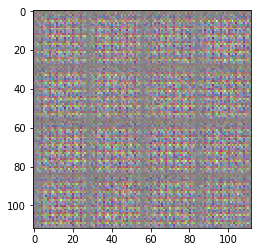

Epoch 1/1... Generator Loss: 4.2857 Discriminator Loss: 0.4496...
Epoch 1/1... Generator Loss: 4.2094 Discriminator Loss: 0.4502...
Epoch 1/1... Generator Loss: 8.0719 Discriminator Loss: 0.8636...
Epoch 1/1... Generator Loss: 3.1031 Discriminator Loss: 0.6151...
Epoch 1/1... Generator Loss: 1.8620 Discriminator Loss: 0.7253...
Epoch 1/1... Generator Loss: 3.8472 Discriminator Loss: 0.6845...
Epoch 1/1... Generator Loss: 1.0514 Discriminator Loss: 1.0843...
Epoch 1/1... Generator Loss: 1.5672 Discriminator Loss: 0.7847...
Epoch 1/1... Generator Loss: 3.4924 Discriminator Loss: 0.4813...
Epoch 1/1... Generator Loss: 2.6151 Discriminator Loss: 0.5084...


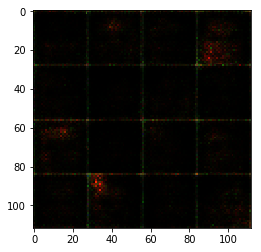

Epoch 1/1... Generator Loss: 3.9205 Discriminator Loss: 0.4332...
Epoch 1/1... Generator Loss: 0.3592 Discriminator Loss: 2.0429...
Epoch 1/1... Generator Loss: 1.4676 Discriminator Loss: 0.8879...
Epoch 1/1... Generator Loss: 2.0811 Discriminator Loss: 0.8072...
Epoch 1/1... Generator Loss: 1.5047 Discriminator Loss: 0.8901...
Epoch 1/1... Generator Loss: 0.7632 Discriminator Loss: 1.2784...
Epoch 1/1... Generator Loss: 0.9773 Discriminator Loss: 1.1508...
Epoch 1/1... Generator Loss: 1.3308 Discriminator Loss: 0.8950...
Epoch 1/1... Generator Loss: 1.9795 Discriminator Loss: 0.9907...
Epoch 1/1... Generator Loss: 2.5717 Discriminator Loss: 0.8171...


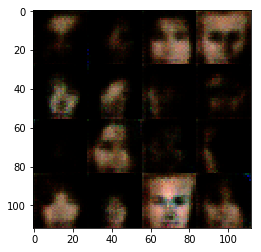

Epoch 1/1... Generator Loss: 1.3230 Discriminator Loss: 0.8547...
Epoch 1/1... Generator Loss: 1.8197 Discriminator Loss: 0.8892...
Epoch 1/1... Generator Loss: 1.6059 Discriminator Loss: 0.9764...
Epoch 1/1... Generator Loss: 0.7496 Discriminator Loss: 1.3063...
Epoch 1/1... Generator Loss: 0.7245 Discriminator Loss: 1.2527...
Epoch 1/1... Generator Loss: 1.2385 Discriminator Loss: 1.1328...
Epoch 1/1... Generator Loss: 1.8097 Discriminator Loss: 1.3393...
Epoch 1/1... Generator Loss: 0.6658 Discriminator Loss: 1.3739...
Epoch 1/1... Generator Loss: 0.8300 Discriminator Loss: 1.1951...
Epoch 1/1... Generator Loss: 0.9271 Discriminator Loss: 1.2595...


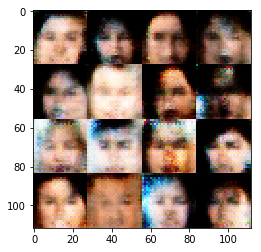

Epoch 1/1... Generator Loss: 0.3454 Discriminator Loss: 1.7071...
Epoch 1/1... Generator Loss: 1.0431 Discriminator Loss: 1.2335...
Epoch 1/1... Generator Loss: 0.4212 Discriminator Loss: 1.6285...
Epoch 1/1... Generator Loss: 1.6012 Discriminator Loss: 1.5174...
Epoch 1/1... Generator Loss: 1.6290 Discriminator Loss: 1.5030...
Epoch 1/1... Generator Loss: 0.9530 Discriminator Loss: 1.3175...
Epoch 1/1... Generator Loss: 1.7910 Discriminator Loss: 1.1006...
Epoch 1/1... Generator Loss: 0.5868 Discriminator Loss: 1.5181...
Epoch 1/1... Generator Loss: 1.4218 Discriminator Loss: 1.3256...
Epoch 1/1... Generator Loss: 0.9931 Discriminator Loss: 1.2759...


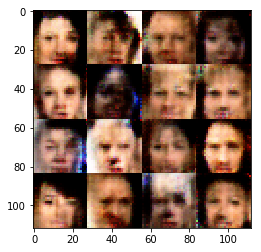

Epoch 1/1... Generator Loss: 0.6125 Discriminator Loss: 1.4621...
Epoch 1/1... Generator Loss: 1.6492 Discriminator Loss: 1.1669...
Epoch 1/1... Generator Loss: 1.8316 Discriminator Loss: 1.4181...
Epoch 1/1... Generator Loss: 0.8951 Discriminator Loss: 1.1265...
Epoch 1/1... Generator Loss: 1.4476 Discriminator Loss: 1.3780...
Epoch 1/1... Generator Loss: 0.8399 Discriminator Loss: 1.3323...
Epoch 1/1... Generator Loss: 1.0841 Discriminator Loss: 1.3292...
Epoch 1/1... Generator Loss: 1.7350 Discriminator Loss: 1.3318...
Epoch 1/1... Generator Loss: 1.2832 Discriminator Loss: 1.2828...
Epoch 1/1... Generator Loss: 1.1651 Discriminator Loss: 1.0747...


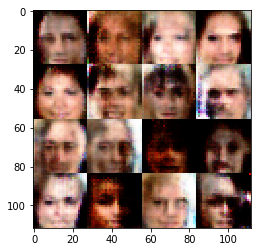

Epoch 1/1... Generator Loss: 1.0754 Discriminator Loss: 1.2960...
Epoch 1/1... Generator Loss: 1.0071 Discriminator Loss: 0.9757...
Epoch 1/1... Generator Loss: 0.9062 Discriminator Loss: 1.2556...
Epoch 1/1... Generator Loss: 0.3969 Discriminator Loss: 1.7447...
Epoch 1/1... Generator Loss: 1.2595 Discriminator Loss: 1.2914...
Epoch 1/1... Generator Loss: 0.6629 Discriminator Loss: 1.3305...
Epoch 1/1... Generator Loss: 0.8334 Discriminator Loss: 1.1855...
Epoch 1/1... Generator Loss: 0.5078 Discriminator Loss: 1.4106...
Epoch 1/1... Generator Loss: 0.6785 Discriminator Loss: 1.3538...
Epoch 1/1... Generator Loss: 1.0652 Discriminator Loss: 1.2812...


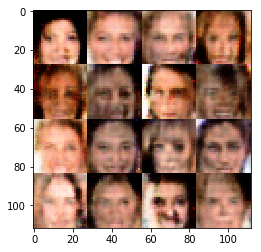

Epoch 1/1... Generator Loss: 1.5543 Discriminator Loss: 1.2835...
Epoch 1/1... Generator Loss: 1.0355 Discriminator Loss: 1.2212...
Epoch 1/1... Generator Loss: 0.6686 Discriminator Loss: 1.4908...
Epoch 1/1... Generator Loss: 1.2309 Discriminator Loss: 1.3061...
Epoch 1/1... Generator Loss: 0.7283 Discriminator Loss: 1.3211...
Epoch 1/1... Generator Loss: 0.9547 Discriminator Loss: 1.3095...
Epoch 1/1... Generator Loss: 1.1730 Discriminator Loss: 1.3100...
Epoch 1/1... Generator Loss: 1.2808 Discriminator Loss: 1.2214...
Epoch 1/1... Generator Loss: 1.1491 Discriminator Loss: 1.2613...
Epoch 1/1... Generator Loss: 0.6947 Discriminator Loss: 1.3139...


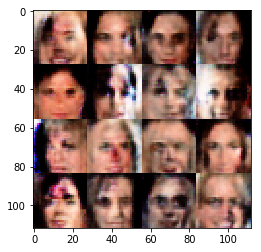

Epoch 1/1... Generator Loss: 0.6457 Discriminator Loss: 1.3379...
Epoch 1/1... Generator Loss: 0.9806 Discriminator Loss: 1.2489...
Epoch 1/1... Generator Loss: 1.7209 Discriminator Loss: 1.4596...
Epoch 1/1... Generator Loss: 0.8811 Discriminator Loss: 1.1528...
Epoch 1/1... Generator Loss: 0.6811 Discriminator Loss: 1.3071...
Epoch 1/1... Generator Loss: 1.0805 Discriminator Loss: 1.3480...
Epoch 1/1... Generator Loss: 0.5837 Discriminator Loss: 1.3571...
Epoch 1/1... Generator Loss: 0.5877 Discriminator Loss: 1.2894...
Epoch 1/1... Generator Loss: 0.6601 Discriminator Loss: 1.3569...
Epoch 1/1... Generator Loss: 1.0019 Discriminator Loss: 1.2145...


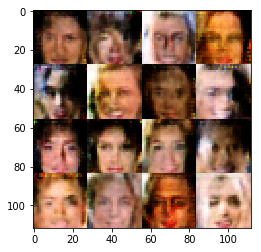

Epoch 1/1... Generator Loss: 0.9308 Discriminator Loss: 1.2258...
Epoch 1/1... Generator Loss: 1.2152 Discriminator Loss: 1.1578...
Epoch 1/1... Generator Loss: 0.8224 Discriminator Loss: 1.2600...
Epoch 1/1... Generator Loss: 1.0698 Discriminator Loss: 1.2014...
Epoch 1/1... Generator Loss: 0.9170 Discriminator Loss: 1.3052...
Epoch 1/1... Generator Loss: 0.8413 Discriminator Loss: 1.3071...
Epoch 1/1... Generator Loss: 0.8663 Discriminator Loss: 1.1554...
Epoch 1/1... Generator Loss: 1.7243 Discriminator Loss: 1.4140...
Epoch 1/1... Generator Loss: 0.5177 Discriminator Loss: 1.4464...
Epoch 1/1... Generator Loss: 0.5559 Discriminator Loss: 1.4379...


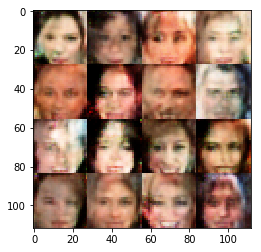

Epoch 1/1... Generator Loss: 1.3057 Discriminator Loss: 1.2833...
Epoch 1/1... Generator Loss: 0.6133 Discriminator Loss: 1.3768...
Epoch 1/1... Generator Loss: 0.7987 Discriminator Loss: 1.2327...
Epoch 1/1... Generator Loss: 0.7059 Discriminator Loss: 1.3133...
Epoch 1/1... Generator Loss: 1.0998 Discriminator Loss: 1.3883...
Epoch 1/1... Generator Loss: 1.0029 Discriminator Loss: 1.2175...
Epoch 1/1... Generator Loss: 0.8430 Discriminator Loss: 1.2654...
Epoch 1/1... Generator Loss: 1.0239 Discriminator Loss: 1.3350...
Epoch 1/1... Generator Loss: 1.0787 Discriminator Loss: 1.1393...
Epoch 1/1... Generator Loss: 1.2182 Discriminator Loss: 1.4255...


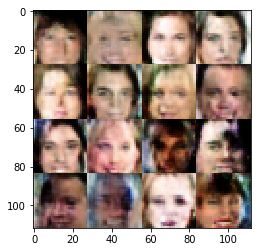

Epoch 1/1... Generator Loss: 0.9671 Discriminator Loss: 1.2809...
Epoch 1/1... Generator Loss: 1.4195 Discriminator Loss: 1.2882...
Epoch 1/1... Generator Loss: 1.3740 Discriminator Loss: 1.3083...
Epoch 1/1... Generator Loss: 0.9469 Discriminator Loss: 1.3226...
Epoch 1/1... Generator Loss: 0.6920 Discriminator Loss: 1.2719...
Epoch 1/1... Generator Loss: 0.7290 Discriminator Loss: 1.2209...
Epoch 1/1... Generator Loss: 1.1632 Discriminator Loss: 1.4107...
Epoch 1/1... Generator Loss: 0.9342 Discriminator Loss: 1.2151...
Epoch 1/1... Generator Loss: 0.6374 Discriminator Loss: 1.4296...
Epoch 1/1... Generator Loss: 0.9495 Discriminator Loss: 1.2274...


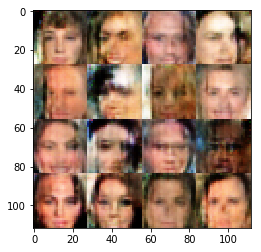

Epoch 1/1... Generator Loss: 0.9312 Discriminator Loss: 1.2325...
Epoch 1/1... Generator Loss: 0.6680 Discriminator Loss: 1.3640...
Epoch 1/1... Generator Loss: 0.9220 Discriminator Loss: 1.3014...
Epoch 1/1... Generator Loss: 0.6885 Discriminator Loss: 1.3919...
Epoch 1/1... Generator Loss: 0.9565 Discriminator Loss: 1.1716...
Epoch 1/1... Generator Loss: 0.8277 Discriminator Loss: 1.1832...
Epoch 1/1... Generator Loss: 0.8548 Discriminator Loss: 1.2791...
Epoch 1/1... Generator Loss: 0.8383 Discriminator Loss: 1.1890...
Epoch 1/1... Generator Loss: 0.8842 Discriminator Loss: 1.1855...
Epoch 1/1... Generator Loss: 1.0117 Discriminator Loss: 1.3313...


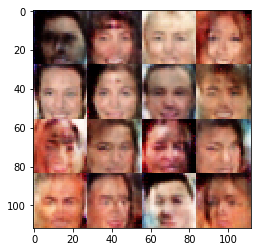

Epoch 1/1... Generator Loss: 0.8946 Discriminator Loss: 1.3625...
Epoch 1/1... Generator Loss: 0.6011 Discriminator Loss: 1.4241...
Epoch 1/1... Generator Loss: 1.0179 Discriminator Loss: 1.2224...
Epoch 1/1... Generator Loss: 0.7604 Discriminator Loss: 1.2739...
Epoch 1/1... Generator Loss: 1.0017 Discriminator Loss: 1.2175...
Epoch 1/1... Generator Loss: 1.4162 Discriminator Loss: 1.4793...
Epoch 1/1... Generator Loss: 0.8399 Discriminator Loss: 1.3103...
Epoch 1/1... Generator Loss: 0.8393 Discriminator Loss: 1.3166...
Epoch 1/1... Generator Loss: 1.1208 Discriminator Loss: 1.3298...
Epoch 1/1... Generator Loss: 0.8774 Discriminator Loss: 1.2802...


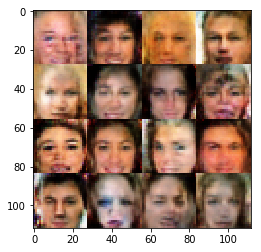

Epoch 1/1... Generator Loss: 0.9109 Discriminator Loss: 1.3231...
Epoch 1/1... Generator Loss: 0.9989 Discriminator Loss: 1.2994...
Epoch 1/1... Generator Loss: 0.9553 Discriminator Loss: 1.3512...
Epoch 1/1... Generator Loss: 0.5012 Discriminator Loss: 1.4343...
Epoch 1/1... Generator Loss: 0.9587 Discriminator Loss: 1.1915...
Epoch 1/1... Generator Loss: 0.8126 Discriminator Loss: 1.3308...
Epoch 1/1... Generator Loss: 0.8839 Discriminator Loss: 1.2765...
Epoch 1/1... Generator Loss: 0.8276 Discriminator Loss: 1.2813...
Epoch 1/1... Generator Loss: 1.0590 Discriminator Loss: 1.3822...
Epoch 1/1... Generator Loss: 0.8416 Discriminator Loss: 1.4445...


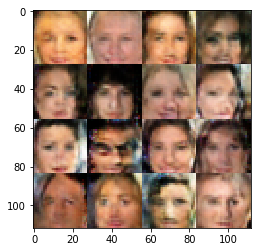

Epoch 1/1... Generator Loss: 1.1647 Discriminator Loss: 1.3413...
Epoch 1/1... Generator Loss: 1.1334 Discriminator Loss: 1.2421...
Epoch 1/1... Generator Loss: 0.9291 Discriminator Loss: 1.2640...
Epoch 1/1... Generator Loss: 0.9103 Discriminator Loss: 1.2702...
Epoch 1/1... Generator Loss: 1.0150 Discriminator Loss: 1.2144...
Epoch 1/1... Generator Loss: 0.7043 Discriminator Loss: 1.3155...
Epoch 1/1... Generator Loss: 0.6692 Discriminator Loss: 1.4129...
Epoch 1/1... Generator Loss: 0.7911 Discriminator Loss: 1.4045...
Epoch 1/1... Generator Loss: 0.8780 Discriminator Loss: 1.3092...
Epoch 1/1... Generator Loss: 0.9380 Discriminator Loss: 1.2121...


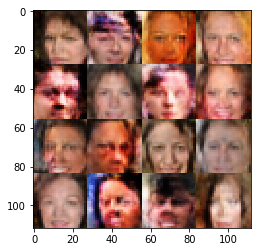

Epoch 1/1... Generator Loss: 0.9985 Discriminator Loss: 1.2026...
Epoch 1/1... Generator Loss: 0.9843 Discriminator Loss: 1.4133...
Epoch 1/1... Generator Loss: 0.9651 Discriminator Loss: 1.2602...
Epoch 1/1... Generator Loss: 0.9813 Discriminator Loss: 1.3236...
Epoch 1/1... Generator Loss: 1.1129 Discriminator Loss: 1.4009...
Epoch 1/1... Generator Loss: 0.9820 Discriminator Loss: 1.2020...
Epoch 1/1... Generator Loss: 0.8078 Discriminator Loss: 1.3444...
Epoch 1/1... Generator Loss: 0.8256 Discriminator Loss: 1.3031...
Epoch 1/1... Generator Loss: 0.8465 Discriminator Loss: 1.3179...
Epoch 1/1... Generator Loss: 1.0461 Discriminator Loss: 1.3499...


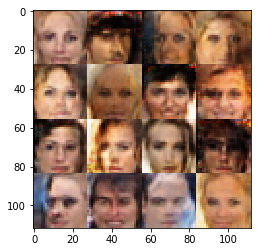

Epoch 1/1... Generator Loss: 0.6093 Discriminator Loss: 1.4304...
Epoch 1/1... Generator Loss: 0.9272 Discriminator Loss: 1.3167...
Epoch 1/1... Generator Loss: 1.0648 Discriminator Loss: 1.3805...
Epoch 1/1... Generator Loss: 1.0162 Discriminator Loss: 1.2733...
Epoch 1/1... Generator Loss: 0.6376 Discriminator Loss: 1.4526...
Epoch 1/1... Generator Loss: 0.7958 Discriminator Loss: 1.3882...
Epoch 1/1... Generator Loss: 1.0465 Discriminator Loss: 1.1568...
Epoch 1/1... Generator Loss: 1.1176 Discriminator Loss: 1.2161...
Epoch 1/1... Generator Loss: 0.6798 Discriminator Loss: 1.3722...
Epoch 1/1... Generator Loss: 0.7065 Discriminator Loss: 1.3676...


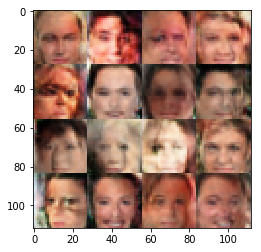

Epoch 1/1... Generator Loss: 0.8248 Discriminator Loss: 1.2553...
Epoch 1/1... Generator Loss: 0.6301 Discriminator Loss: 1.4023...
Epoch 1/1... Generator Loss: 0.9224 Discriminator Loss: 1.3300...
Epoch 1/1... Generator Loss: 0.8647 Discriminator Loss: 1.4394...
Epoch 1/1... Generator Loss: 1.1125 Discriminator Loss: 1.3124...
Epoch 1/1... Generator Loss: 0.8600 Discriminator Loss: 1.2848...
Epoch 1/1... Generator Loss: 0.9794 Discriminator Loss: 1.2754...
Epoch 1/1... Generator Loss: 0.9791 Discriminator Loss: 1.1836...
Epoch 1/1... Generator Loss: 0.9097 Discriminator Loss: 1.2284...
Epoch 1/1... Generator Loss: 0.8293 Discriminator Loss: 1.3259...


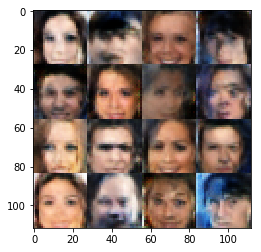

Epoch 1/1... Generator Loss: 0.9322 Discriminator Loss: 1.3064...
Epoch 1/1... Generator Loss: 0.7709 Discriminator Loss: 1.3371...
Epoch 1/1... Generator Loss: 0.8579 Discriminator Loss: 1.2561...
Epoch 1/1... Generator Loss: 0.7435 Discriminator Loss: 1.3521...
Epoch 1/1... Generator Loss: 0.9012 Discriminator Loss: 1.2262...
Epoch 1/1... Generator Loss: 1.0182 Discriminator Loss: 1.2640...
Epoch 1/1... Generator Loss: 0.7073 Discriminator Loss: 1.3755...
Epoch 1/1... Generator Loss: 0.9333 Discriminator Loss: 1.3277...
Epoch 1/1... Generator Loss: 0.7879 Discriminator Loss: 1.3231...
Epoch 1/1... Generator Loss: 0.8034 Discriminator Loss: 1.2516...


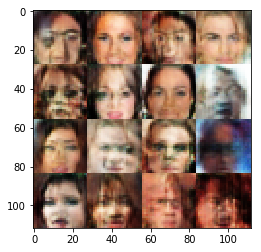

Epoch 1/1... Generator Loss: 0.7731 Discriminator Loss: 1.3043...
Epoch 1/1... Generator Loss: 0.8363 Discriminator Loss: 1.4090...
Epoch 1/1... Generator Loss: 0.7834 Discriminator Loss: 1.3390...
Epoch 1/1... Generator Loss: 1.1456 Discriminator Loss: 1.2838...
Epoch 1/1... Generator Loss: 0.8837 Discriminator Loss: 1.2631...
Epoch 1/1... Generator Loss: 0.7565 Discriminator Loss: 1.2270...
Epoch 1/1... Generator Loss: 0.7404 Discriminator Loss: 1.3250...
Epoch 1/1... Generator Loss: 0.6972 Discriminator Loss: 1.3397...
Epoch 1/1... Generator Loss: 0.9634 Discriminator Loss: 1.2614...
Epoch 1/1... Generator Loss: 0.8880 Discriminator Loss: 1.2823...


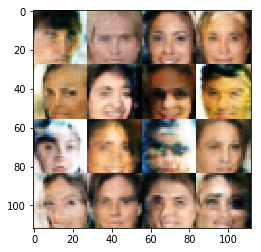

Epoch 1/1... Generator Loss: 0.7598 Discriminator Loss: 1.2423...
Epoch 1/1... Generator Loss: 0.7868 Discriminator Loss: 1.3247...
Epoch 1/1... Generator Loss: 0.7573 Discriminator Loss: 1.3248...
Epoch 1/1... Generator Loss: 1.5095 Discriminator Loss: 1.4501...
Epoch 1/1... Generator Loss: 0.7886 Discriminator Loss: 1.3391...
Epoch 1/1... Generator Loss: 0.9867 Discriminator Loss: 1.1322...
Epoch 1/1... Generator Loss: 0.8784 Discriminator Loss: 1.2915...
Epoch 1/1... Generator Loss: 1.0662 Discriminator Loss: 1.2710...
Epoch 1/1... Generator Loss: 0.7696 Discriminator Loss: 1.2315...
Epoch 1/1... Generator Loss: 0.6796 Discriminator Loss: 1.2943...


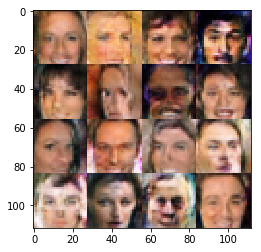

Epoch 1/1... Generator Loss: 0.7256 Discriminator Loss: 1.3135...
Epoch 1/1... Generator Loss: 1.0371 Discriminator Loss: 1.2823...
Epoch 1/1... Generator Loss: 0.7951 Discriminator Loss: 1.2816...
Epoch 1/1... Generator Loss: 0.8903 Discriminator Loss: 1.2583...
Epoch 1/1... Generator Loss: 0.8192 Discriminator Loss: 1.2991...
Epoch 1/1... Generator Loss: 0.9342 Discriminator Loss: 1.3578...
Epoch 1/1... Generator Loss: 0.8850 Discriminator Loss: 1.2421...
Epoch 1/1... Generator Loss: 0.9499 Discriminator Loss: 1.3252...
Epoch 1/1... Generator Loss: 0.8202 Discriminator Loss: 1.2647...
Epoch 1/1... Generator Loss: 0.8021 Discriminator Loss: 1.3444...


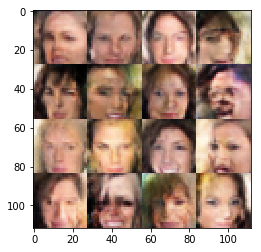

Epoch 1/1... Generator Loss: 0.9438 Discriminator Loss: 1.2860...
Epoch 1/1... Generator Loss: 0.9177 Discriminator Loss: 1.2408...
Epoch 1/1... Generator Loss: 0.7997 Discriminator Loss: 1.3391...
Epoch 1/1... Generator Loss: 0.8081 Discriminator Loss: 1.3469...
Epoch 1/1... Generator Loss: 0.7634 Discriminator Loss: 1.3133...
Epoch 1/1... Generator Loss: 0.6840 Discriminator Loss: 1.3839...
Epoch 1/1... Generator Loss: 0.8858 Discriminator Loss: 1.3459...
Epoch 1/1... Generator Loss: 1.0154 Discriminator Loss: 1.2612...
Epoch 1/1... Generator Loss: 0.8913 Discriminator Loss: 1.2033...
Epoch 1/1... Generator Loss: 0.5941 Discriminator Loss: 1.4522...


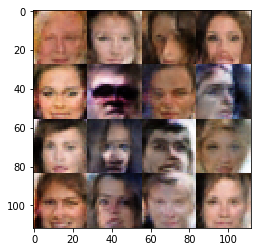

Epoch 1/1... Generator Loss: 0.6727 Discriminator Loss: 1.3733...
Epoch 1/1... Generator Loss: 0.9623 Discriminator Loss: 1.2305...
Epoch 1/1... Generator Loss: 0.8382 Discriminator Loss: 1.1939...
Epoch 1/1... Generator Loss: 0.9059 Discriminator Loss: 1.2537...
Epoch 1/1... Generator Loss: 0.7283 Discriminator Loss: 1.3718...
Epoch 1/1... Generator Loss: 0.7430 Discriminator Loss: 1.4368...
Epoch 1/1... Generator Loss: 1.0480 Discriminator Loss: 1.2591...
Epoch 1/1... Generator Loss: 0.8453 Discriminator Loss: 1.2766...
Epoch 1/1... Generator Loss: 0.8307 Discriminator Loss: 1.2681...
Epoch 1/1... Generator Loss: 0.6797 Discriminator Loss: 1.4054...


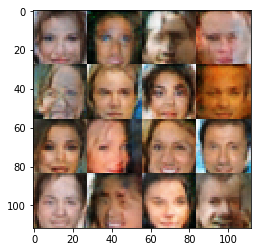

Epoch 1/1... Generator Loss: 0.8498 Discriminator Loss: 1.4271...
Epoch 1/1... Generator Loss: 0.8223 Discriminator Loss: 1.3715...
Epoch 1/1... Generator Loss: 0.8714 Discriminator Loss: 1.2758...
Epoch 1/1... Generator Loss: 0.8012 Discriminator Loss: 1.3541...
Epoch 1/1... Generator Loss: 0.8211 Discriminator Loss: 1.3442...
Epoch 1/1... Generator Loss: 0.9028 Discriminator Loss: 1.3803...
Epoch 1/1... Generator Loss: 0.7406 Discriminator Loss: 1.3632...
Epoch 1/1... Generator Loss: 0.9151 Discriminator Loss: 1.2402...
Epoch 1/1... Generator Loss: 0.9140 Discriminator Loss: 1.3156...
Epoch 1/1... Generator Loss: 0.8407 Discriminator Loss: 1.2756...


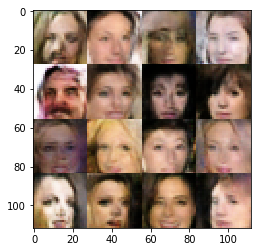

Epoch 1/1... Generator Loss: 0.7170 Discriminator Loss: 1.3238...
Epoch 1/1... Generator Loss: 0.9186 Discriminator Loss: 1.4218...
Epoch 1/1... Generator Loss: 0.7136 Discriminator Loss: 1.4551...
Epoch 1/1... Generator Loss: 0.8588 Discriminator Loss: 1.3496...
Epoch 1/1... Generator Loss: 0.8453 Discriminator Loss: 1.2736...
Epoch 1/1... Generator Loss: 1.2532 Discriminator Loss: 1.2743...
Epoch 1/1... Generator Loss: 0.9684 Discriminator Loss: 1.2045...
Epoch 1/1... Generator Loss: 0.7561 Discriminator Loss: 1.3075...
Epoch 1/1... Generator Loss: 0.8048 Discriminator Loss: 1.2884...
Epoch 1/1... Generator Loss: 0.9783 Discriminator Loss: 1.3526...


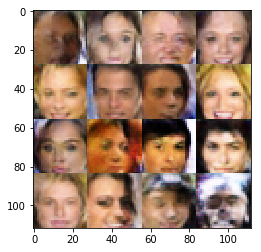

Epoch 1/1... Generator Loss: 0.8223 Discriminator Loss: 1.3696...
Epoch 1/1... Generator Loss: 0.7599 Discriminator Loss: 1.2837...
Epoch 1/1... Generator Loss: 0.6499 Discriminator Loss: 1.3834...
Epoch 1/1... Generator Loss: 0.6798 Discriminator Loss: 1.3134...
Epoch 1/1... Generator Loss: 0.8297 Discriminator Loss: 1.3003...
Epoch 1/1... Generator Loss: 0.8531 Discriminator Loss: 1.2947...
Epoch 1/1... Generator Loss: 0.7968 Discriminator Loss: 1.3622...
Epoch 1/1... Generator Loss: 0.9528 Discriminator Loss: 1.2740...
Epoch 1/1... Generator Loss: 0.7982 Discriminator Loss: 1.3135...
Epoch 1/1... Generator Loss: 0.7936 Discriminator Loss: 1.2457...


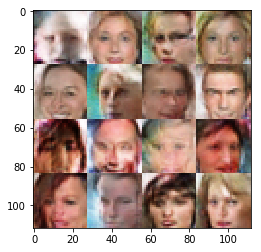

Epoch 1/1... Generator Loss: 0.7577 Discriminator Loss: 1.3767...
Epoch 1/1... Generator Loss: 0.7924 Discriminator Loss: 1.3595...
Epoch 1/1... Generator Loss: 0.7893 Discriminator Loss: 1.3708...
Epoch 1/1... Generator Loss: 0.9046 Discriminator Loss: 1.3451...
Epoch 1/1... Generator Loss: 0.8893 Discriminator Loss: 1.2363...
Epoch 1/1... Generator Loss: 0.8125 Discriminator Loss: 1.3556...
Epoch 1/1... Generator Loss: 0.7611 Discriminator Loss: 1.3629...
Epoch 1/1... Generator Loss: 1.0018 Discriminator Loss: 1.2532...
Epoch 1/1... Generator Loss: 0.8430 Discriminator Loss: 1.3331...
Epoch 1/1... Generator Loss: 0.7653 Discriminator Loss: 1.2992...


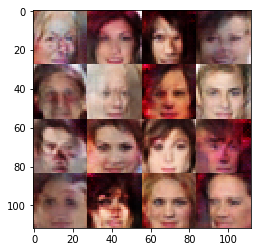

Epoch 1/1... Generator Loss: 0.7197 Discriminator Loss: 1.3946...
Epoch 1/1... Generator Loss: 0.8153 Discriminator Loss: 1.3566...
Epoch 1/1... Generator Loss: 0.8460 Discriminator Loss: 1.3264...
Epoch 1/1... Generator Loss: 0.7386 Discriminator Loss: 1.3493...
Epoch 1/1... Generator Loss: 0.7216 Discriminator Loss: 1.3435...
Epoch 1/1... Generator Loss: 1.2473 Discriminator Loss: 1.4281...
Epoch 1/1... Generator Loss: 0.8083 Discriminator Loss: 1.3954...
Epoch 1/1... Generator Loss: 0.8784 Discriminator Loss: 1.3718...
Epoch 1/1... Generator Loss: 0.6969 Discriminator Loss: 1.3532...
Epoch 1/1... Generator Loss: 1.0148 Discriminator Loss: 1.4512...


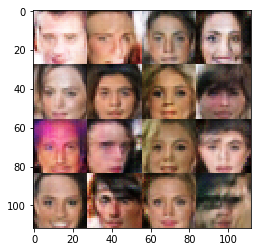

Epoch 1/1... Generator Loss: 0.8546 Discriminator Loss: 1.3716...
Epoch 1/1... Generator Loss: 0.9317 Discriminator Loss: 1.3114...
Epoch 1/1... Generator Loss: 0.9423 Discriminator Loss: 1.3535...
Epoch 1/1... Generator Loss: 0.7521 Discriminator Loss: 1.3423...
Epoch 1/1... Generator Loss: 0.7878 Discriminator Loss: 1.3119...
Epoch 1/1... Generator Loss: 0.8664 Discriminator Loss: 1.3478...
Epoch 1/1... Generator Loss: 0.7527 Discriminator Loss: 1.2749...
Epoch 1/1... Generator Loss: 1.0084 Discriminator Loss: 1.2231...
Epoch 1/1... Generator Loss: 1.0645 Discriminator Loss: 1.2867...
Epoch 1/1... Generator Loss: 0.9054 Discriminator Loss: 1.2207...


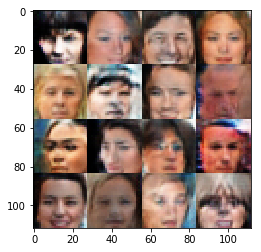

Epoch 1/1... Generator Loss: 0.7179 Discriminator Loss: 1.3946...
Epoch 1/1... Generator Loss: 0.7089 Discriminator Loss: 1.3817...
Epoch 1/1... Generator Loss: 0.7921 Discriminator Loss: 1.2807...
Epoch 1/1... Generator Loss: 0.8646 Discriminator Loss: 1.2696...
Epoch 1/1... Generator Loss: 0.9050 Discriminator Loss: 1.3355...
Epoch 1/1... Generator Loss: 0.9465 Discriminator Loss: 1.3716...
Epoch 1/1... Generator Loss: 0.7809 Discriminator Loss: 1.2966...
Epoch 1/1... Generator Loss: 0.8288 Discriminator Loss: 1.2901...
Epoch 1/1... Generator Loss: 0.8484 Discriminator Loss: 1.2991...
Epoch 1/1... Generator Loss: 0.7046 Discriminator Loss: 1.3673...


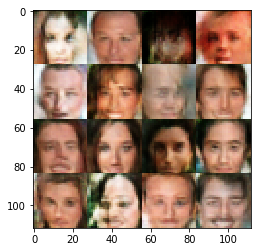

Epoch 1/1... Generator Loss: 0.9874 Discriminator Loss: 1.1995...
Epoch 1/1... Generator Loss: 0.8549 Discriminator Loss: 1.3741...
Epoch 1/1... Generator Loss: 0.9841 Discriminator Loss: 1.2200...
Epoch 1/1... Generator Loss: 0.7641 Discriminator Loss: 1.3765...
Epoch 1/1... Generator Loss: 0.8841 Discriminator Loss: 1.2627...
Epoch 1/1... Generator Loss: 0.8233 Discriminator Loss: 1.3339...


In [28]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.